In [ ]:
# Extracting some visible features from the synthetically generated images. We again generate synthetic cell images based on the vectors obtained in the previous step.
# We also used certain visualization techniques to identify changes across clusters.
# Code written by A Siddharth Reddy

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure
import skimage.feature
from skimage import io, color, img_as_ubyte
import pandas as pd
import cv2
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Function to extract features from an image
def extract_features(image):
    # Conversion to grayscale if not already
    if len(image.shape) == 3:
        image = color.rgb2gray(image)

    # Thresholding the image to create a binary image
    binary_image = image > np.mean(image)

    # Labeling connected components
    label_image = skimage.measure.label(binary_image)

    # To get region properties
    regions = skimage.measure.regionprops(label_image, intensity_image=image)

    features = []

    for region in regions:
        # We skip small regions
        if region.area < 10:
            continue

        # Basic properties
        area = region.area
        perimeter = region.perimeter
        aspect_ratio = region.major_axis_length / region.minor_axis_length if region.minor_axis_length != 0 else 0
        extent = region.extent
        solidity = region.solidity

        # Intensity features
        mean_intensity = region.mean_intensity
        std_intensity = np.std(region.intensity_image[region.image])

        # Texture features using GLCM
        glcm = skimage.feature.graycomatrix(img_as_ubyte(region.intensity_image), distances=[1], angles=[0], symmetric=True, normed=True)
        contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = skimage.feature.graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = skimage.feature.graycoprops(glcm, 'homogeneity')[0, 0]
        asm = skimage.feature.graycoprops(glcm, 'ASM')[0, 0]
        energy = skimage.feature.graycoprops(glcm, 'energy')[0, 0]

        # Appending all features to the list
        features.append({
            'Area': area,
            'Perimeter': perimeter,
            'Aspect Ratio': aspect_ratio,
            'Extent': extent,
            'Solidity': solidity,
            'Mean Intensity': mean_intensity,
            'Std Intensity': std_intensity,
            'Contrast': contrast,
            'Dissimilarity': dissimilarity,
            'Homogeneity': homogeneity,
            'ASM': asm,
            'Energy': energy
        })

    return features

In [ ]:
# Function to process all images in a folder
def process_images_in_folder(folder_path, output_csv):
    all_features = []

    for file_name in os.listdir(folder_path):
        # We can adjust the file extension if needed
        if file_name.endswith('.png'):
            file_path = os.path.join(folder_path, file_name)
            image = io.imread(file_path)
            features = extract_features(image)

            # Adding filename to each feature dictionary for reference
            for feature in features:
                feature['File Name'] = file_name

            all_features.extend(features)

    # Saving all the features to a CSV file
    df = pd.DataFrame(all_features)
    df.to_csv(output_csv, index=False)

In [ ]:
# Function to create a synthetic image based on the features
def create_synthetic_image(features, image_size=(100, 100)):
    img = np.zeros(image_size, dtype=np.uint8)
    mask = np.zeros(image_size, dtype=np.uint8)
    center = (image_size[1] // 2, image_size[0] // 2)
    axis_length = (int(features['Aspect Ratio'] * 10), 10)  # Using aspect ratio for ellipse dimensions
    angle = 0
    start_angle = 0
    end_angle = 360

    # Drawing an ellipse to represent the cell shape
    cv2.ellipse(mask, center, axis_length, angle, start_angle, end_angle, 255, -1)
    img[mask == 255] = int(features['Mean Intensity'])  # Set the cell area to the mean intensity

    # Adding texture to represent homogeneity within the cell area
    if features['Homogeneity'] > 0:
        noise = np.random.normal(loc=0, scale=features['Std Intensity'], size=image_size).astype(np.uint8)
        img = cv2.addWeighted(img, 1, noise, 0.3, 0)
        img[mask == 0] = 0  # Ensuring the background remains black

    # Drawing perimeter as a boundary around the mask
    perimeter_points = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cv2.drawContours(img, perimeter_points, -1, (255), 1)  # Fixed thickness for visibility

    return img

In [ ]:
# Specifying the folder containing synthetic images and the output CSV file path
folder_path = '/content/drive/MyDrive/synthetic_imgs'
output_csv = 'synthetic_images_features.csv'


In [ ]:
# Processing all images in the specified folder and save the features to a CSV file
process_images_in_folder(folder_path, output_csv)

In [ ]:
# Loading the CSV file containing the features
csv_file_path = 'synthetic_images_features.csv'
df = pd.read_csv(csv_file_path)

In [ ]:
# Generates and saves synthetic images for each row in the CSV
output_folder = 'generated_synthetic_images'
os.makedirs(output_folder, exist_ok=True)

In [ ]:
for index, row in df.iterrows():
    synthetic_img = create_synthetic_image(row)

    # Saves the synthetic image
    file_name = f'synthetic_image_{index}.png'
    file_path = os.path.join(output_folder, file_name)
    cv2.imwrite(file_path, synthetic_img)

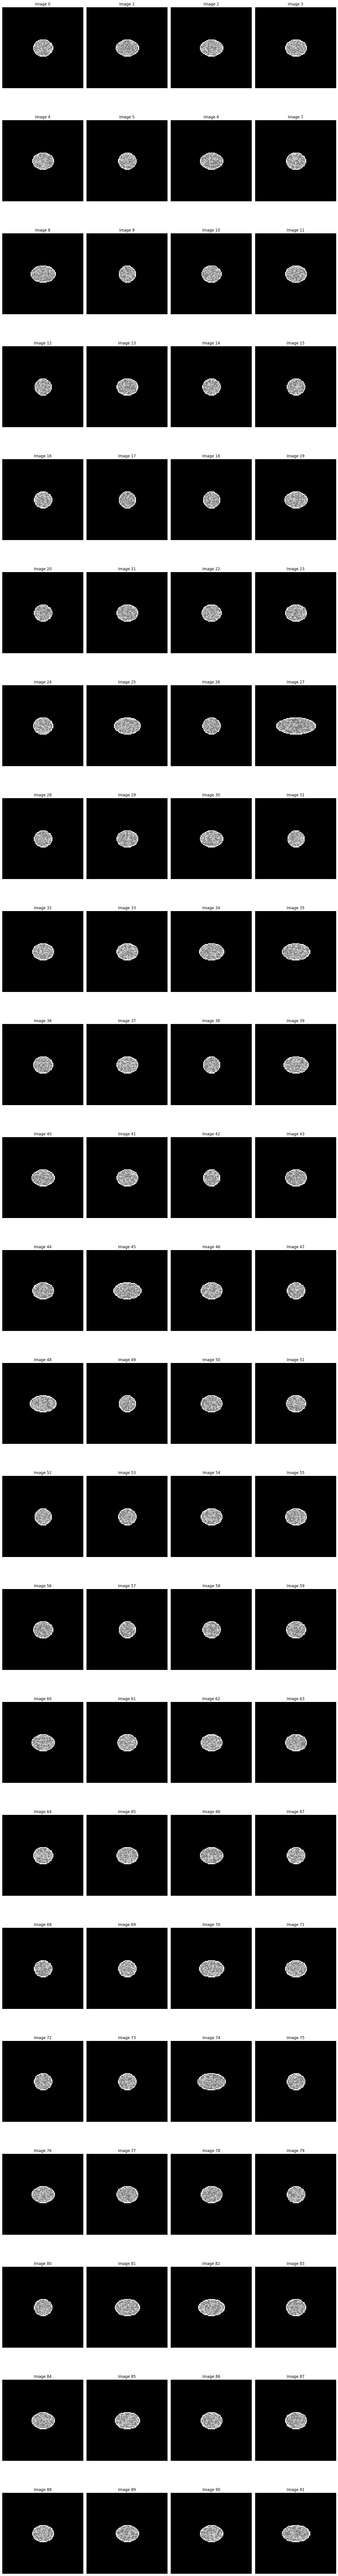

In [ ]:
# Displays a few generated synthetic images
num_images_to_display = 92
cols = 4
# To calculate number of rows needed
rows = (num_images_to_display + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

for i in range(min(num_images_to_display, len(df))):
    synthetic_img = cv2.imread(os.path.join(output_folder, f'synthetic_image_{i}.png'), cv2.IMREAD_GRAYSCALE)

    # Displays the synthetic image
    row, col = divmod(i, cols)
    ax = axes[row, col]
    ax.imshow(synthetic_img, cmap='gray')
    ax.set_title(f'Image {i}')
    ax.axis('off')

# Turns off unused subplots
for j in range(i + 1, rows * cols):
    row, col = divmod(j, cols)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Clustering and analysis
# To normalize the features for clustering
features = df.drop(columns=['File Name'])
normalized_features = (features - features.mean()) / features.std()

# Apply K-Means clustering
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# Identify changes across clusters
cluster_centers = kmeans.cluster_centers_  # Calculate cluster centers
feature_changes = pd.DataFrame(cluster_centers, columns=features.columns)
print("Cluster Centers (Mean Feature Vectors):\n", feature_changes)

Cluster Centers (Mean Feature Vectors):
         Area  Perimeter  Aspect Ratio    Extent  Solidity  Mean Intensity  \
0   1.242319   0.958707     -0.106644 -0.317551 -0.887032        0.056431   
1  -0.884141  -0.859875      0.248084  1.374990  1.366732       -0.813054   
2  -1.190574  -1.279778     -1.516622 -3.111896  1.366732        0.894712   
3  -0.157781  -0.033376      1.017375  0.041657 -0.190465        0.542645   
4   3.882595   6.139899     -1.188082  0.549381 -2.137141        1.106199   
5   0.338187   0.404471      1.747914  0.086646 -0.487304       -0.296118   
6  -0.076444   0.012541     -0.532593 -0.219363 -1.255633        0.455205   
7  -1.071405  -1.008333      4.931654  2.192912  1.366732       -1.429708   
8  -0.590949  -0.501899     -0.779351  0.158927 -0.000859       -0.027838   
9  -0.441515  -0.375723     -1.516622 -0.858066  1.366732       -0.471572   
10 -1.190574  -1.279778     -1.516622 -3.111896  1.366732       -2.728054   
11  0.337335   0.336296      0.2626

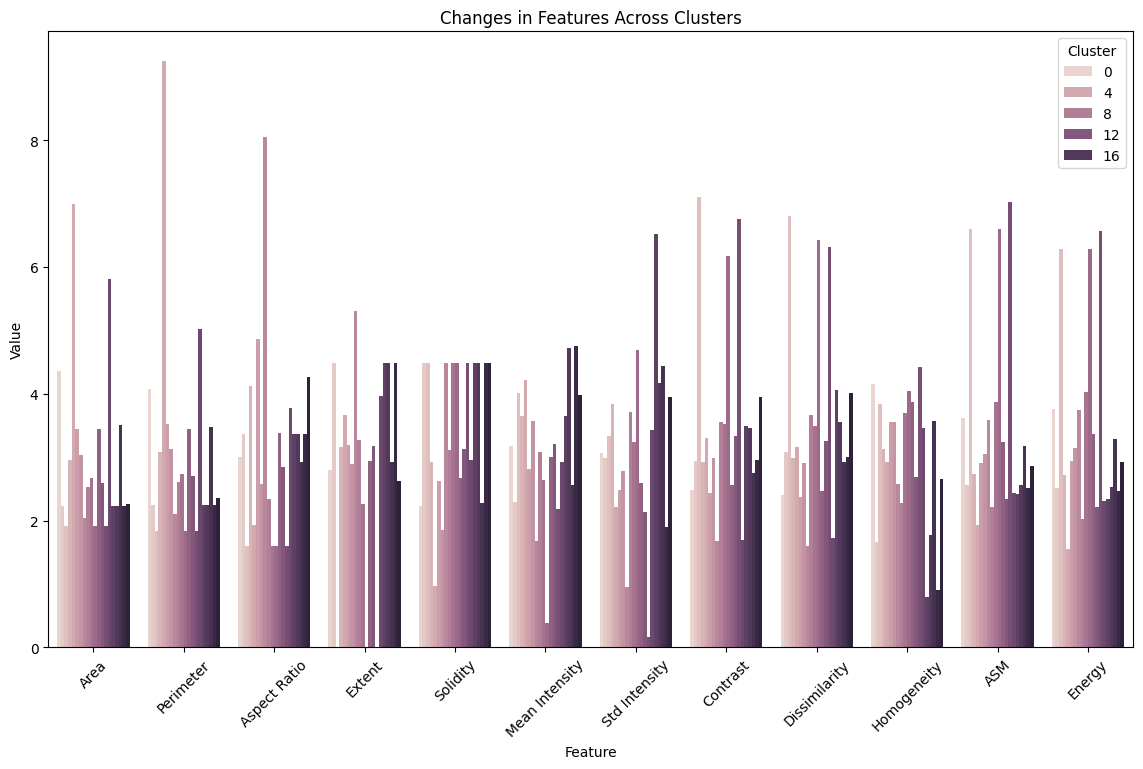

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Normalizes the data by adding the absolute value of the minimum value + a small epsilon
epsilon = 1e-6
feature_changes_melted['Value'] += abs(feature_changes_melted['Value'].min()) + epsilon

# Plotting the changes in features across clusters
plt.figure(figsize=(14, 8))
sns.barplot(x='Feature', y='Value', hue='Cluster', data=feature_changes_melted)
plt.title('Changes in Features Across Clusters')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from scipy.stats import f_oneway

# Performs ANOVA for each feature
significant_features = []
for feature in features.columns:
    groups = [normalized_features[clusters == i][feature] for i in range(num_clusters)]
    f_val, p_val = f_oneway(*groups)
    # Uses 0.05 as the significance level
    if p_val < 0.05:
        significant_features.append((feature, p_val))

print("Significant Features and their p-values:")
print(significant_features)

Significant Features and their p-values:
[('Area', 3.3787539487982814e-33), ('Perimeter', 7.472766724809846e-43), ('Aspect Ratio', 1.6009995494054292e-23), ('Extent', 2.0517597883280953e-55), ('Solidity', 4.53524396493059e-37), ('Mean Intensity', 7.867555366076811e-07), ('Std Intensity', 4.8235858682171435e-15), ('Contrast', 8.344563471068838e-49), ('Dissimilarity', 3.2315036221382595e-49), ('Homogeneity', 4.5022283506421744e-24), ('ASM', 1.3111374564040515e-47), ('Energy', 5.95777122800617e-41)]


In [ ]:
def generate_equation(feature_vector):
    equation = "Synthetic Image = "
    terms = []
    for feature, value in feature_vector.items():
        terms.append(f"{value:.2f} * {feature}")
    equation += " + ".join(terms)
    return equation

# Generates equations for each cluster center
equations = []
for index, center in feature_changes.iterrows():
    equation = generate_equation(center)
    equations.append(f"Cluster {index}: {equation}")

# Displays the equations
for eq in equations:
    print(eq)

Cluster 0: Synthetic Image = 1.24 * Area + 0.96 * Perimeter + -0.11 * Aspect Ratio + -0.32 * Extent + -0.89 * Solidity + 0.06 * Mean Intensity + -0.05 * Std Intensity + -0.62 * Contrast + -0.72 * Dissimilarity + 1.04 * Homogeneity + 0.50 * ASM + 0.65 * Energy
Cluster 1: Synthetic Image = -0.88 * Area + -0.86 * Perimeter + 0.25 * Aspect Ratio + 1.37 * Extent + 1.37 * Solidity + -0.81 * Mean Intensity + -0.13 * Std Intensity + -0.17 * Contrast + -0.04 * Dissimilarity + -1.45 * Homogeneity + -0.56 * ASM + -0.59 * Energy
Cluster 2: Synthetic Image = -1.19 * Area + -1.28 * Perimeter + -1.52 * Aspect Ratio + -3.11 * Extent + 1.37 * Solidity + 0.89 * Mean Intensity + 0.22 * Std Intensity + 3.99 * Contrast + 3.68 * Dissimilarity + 0.73 * Homogeneity + 3.49 * ASM + 3.17 * Energy
Cluster 3: Synthetic Image = -0.16 * Area + -0.03 * Perimeter + 1.02 * Aspect Ratio + 0.04 * Extent + -0.19 * Solidity + 0.54 * Mean Intensity + 0.72 * Std Intensity + -0.18 * Contrast + -0.12 * Dissimilarity + 0.02 * H